# Calculate Compound Years for CESM

This file grabs the warm season indeces and sees if this shows us anything


You need to run cesmTradIndeces.ipnyb first (which in turn requires calculateCesmMonthlyIndeces.ipnyb)

In [54]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
from utils.timePeriod import averageForTimePeriod


In [185]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas

In [56]:
# Here is the data
indecesDa = xarray.load_dataarray('results/cesmTradIndeces.nc')

In [58]:
indecesDa.experiment

<xarray.DataArray 'experiment' (experiment: 18)>
array(['0850cntl.001', 'LME.002', 'LME.003', 'LME.008', 'LME.009', '001',
       '002', '003', '004', '005', '006', '007', '008', '009', '010', '011',
       '012', '013'], dtype=object)
Coordinates:
  * experiment  (experiment) object '0850cntl.001' 'LME.002' ... '012' '013'

So we are going to define events as follows:
- For SST indeces (aka Enso and Iod), this is 1 sigma above/below mean
- For PSL indeces (aka Sam) this is 0.5 sigma above/below mean

For now, using a 850-1850 climatology

In [59]:
# This should calculate stds for all experiments and all indeces
stdDa = indecesDa.std(dim='year')

In [219]:
# define some criteria that we want to use to identifiy it thats an event
criteriaDa = xarray.concat(
    (
        stdDa.sel(index=['nino34','dmi']),
        stdDa.sel(index='sam')/2
    ),
    'index'
)

CESM Model Run: LME.008


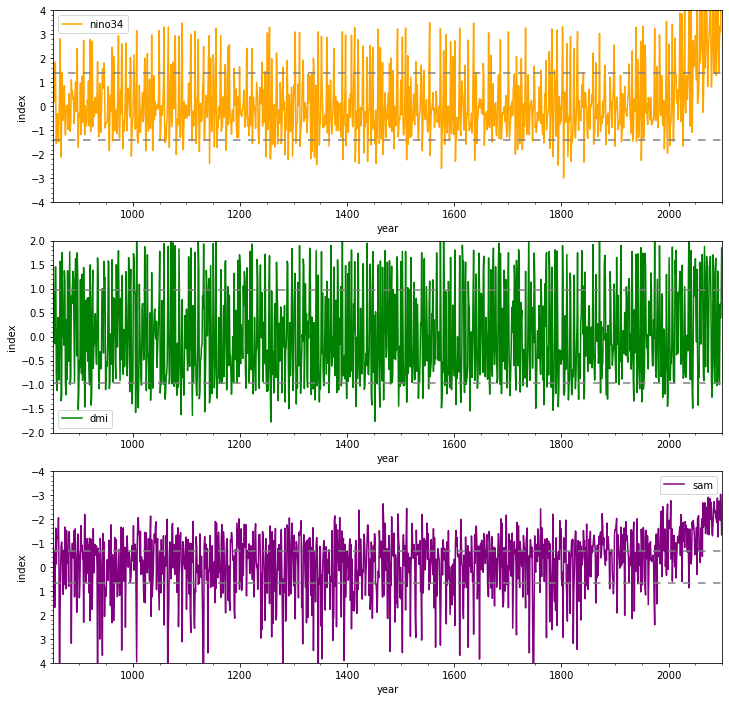

In [220]:
# plot indeces for an experiment, and add some lines for +- 1 sigma

expToPlot = 'LME.008'

indexToPlot = ['nino34', 'dmi', 'sam']

colors = ['orange', 'green', 'purple']

lims = [(-4,4), [-2,2], [4,-4]]

print('CESM Model Run: ' + expToPlot)

# first define somewhere to plot
fig = plt.figure(figsize=(12,12))


for i in range(3):
    
    fig.add_subplot(3,1,i+1)
    
    plotData=indecesDa.sel(experiment=expToPlot, index=indexToPlot[i]) 
    eventCrit=criteriaDa.sel(experiment=expToPlot, index=indexToPlot[i]).values
    
    #colors = numpy.where(plotData.values>eventCrit,'red','orange')

    # plot the actual data
    plt.plot(plotData.year, plotData.values, label=indexToPlot[i], color=colors[i])
    #plt.vlines(x=plotData.year, ymin=0, ymax=plotData.values, label=indexToPlot[i], color=colors[i],)
    
    # draw some horizontal lines for criteria
    plt.axhline(y=eventCrit, dashes=(5,5), color='grey')
    plt.axhline(y=-eventCrit, dashes=(5,5), color='grey')

#Tidy up a bit
#plt.title("CESM Full Forcing Ensemble Run 001")
    plt.xlabel('year')
    plt.ylabel('index')
    plt.ylim(lims[i])
    plt.minorticks_on()
    plt.legend()
    
    plt.xlim(850,2100)
    


Maybe see if the criteria look the same on a plot vs the c

# Calculate the compounding years and plot them

In [231]:
#events are greater than or less than the criteria

#enso and iod events are positive, sam events are negative

posEvents=xarray.concat(
    (
        (indecesDa>criteriaDa).sel(index=['nino34','dmi']),
        (indecesDa<-criteriaDa).sel(index='sam')
    ),
    'index'
)

negEvents=xarray.concat(
    (
        (indecesDa<-criteriaDa).sel(index=['nino34','dmi']),
        (indecesDa>criteriaDa).sel(index='sam')
    ),
    'index'
)

# amazingly you can sum booleans
posCount=posEvents.sum(dim='index')
negCount=-negEvents.sum(dim='index')

(1700.0, 2100.0)

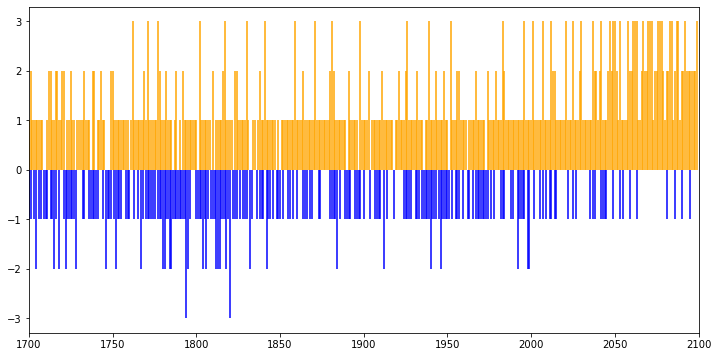

In [232]:
#plot the pos events in orange and the neg count in blue

fig = plt.figure(figsize=(12,6))
plt.vlines(
    x=negCount.year, 
    ymin=negCount.sel(experiment=expToPlot).values,
    ymax=0,
    colors='blue'
)

plt.vlines(
    x=posCount.year, 
    ymin=0,
    ymax=posCount.sel(experiment=expToPlot).values,
    colors='orange'
)
plt.xlim(1700,2100)

# Put the compounds into 30 year intervals

In [233]:
yearBins=numpy.arange(870,2130,30)

In [234]:
binnedPosCount=(posCount>1).groupby_bins('year', yearBins).sum()
binnedNegCount=-(negCount<-1).groupby_bins('year', yearBins).sum()

In [239]:
binnedPosCount.sel(experiment=expToPlot)

<xarray.DataArray (year_bins: 41)>
array([10.,  5.,  7.,  6.,  8.,  4.,  5.,  3.,  6.,  8.,  6.,  7.,  5.,
        4.,  7.,  5.,  5.,  7.,  6.,  6.,  7.,  6.,  5.,  4.,  5.,  6.,
        8.,  6., 10.,  5.,  6.,  7.,  3.,  5.,  4.,  7.,  6.,  5., 10.,
       20., 25.])
Coordinates:
  * year_bins   (year_bins) object (870, 900] (900, 930] ... (2070, 2100]
    experiment  <U7 'LME.008'

In [235]:
#stupidly complicated way to figure out the mid points of my bins?
x = pandas.IntervalIndex(binnedNegCount.year_bins.values).mid

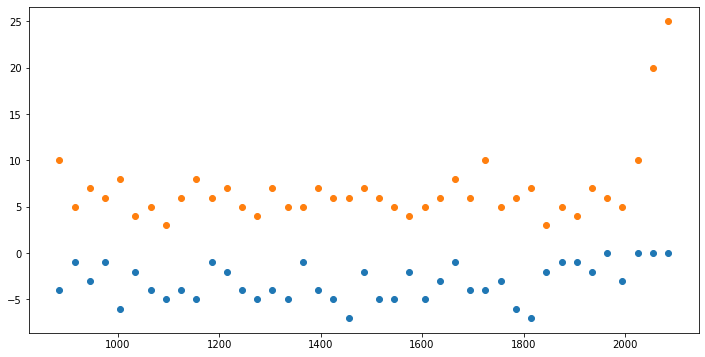

In [246]:
fig = plt.figure(figsize=(12,6))

plt.scatter(x, binnedNegCount.sel(experiment=expToPlot).values)
plt.scatter(x, binnedPosCount.sel(experiment=expToPlot).values)
